## 4. Preprocessing position for decoding

To decode, we need to:
1. Process position from pixel to cm; calculate speed. Table involved: IntervalPositionInfo
2. Linearize position (project 2D position to 1D track graph). Table involved: IntervalLinearizedPosition

In [20]:
%reload_ext autoreload
%autoreload 2

In [2]:
import spyglass as nd
import pandas as pd
import matplotlib.pyplot as plt
from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename
from spyglass.common import IntervalList
from spyglass.common.common_position import IntervalPositionInfo, PositionInfoParameters
from spyglass.common.common_position import IntervalPositionInfoSelection
from spyglass.common.common_position import IntervalLinearizationSelection
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_position import TrackGraph
from spyglass.shijiegu.Analysis_SGU import EpochPos

[2025-06-12 07:45:53,577][INFO]: DataJoint 0.14.4 connected to shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [3]:
# test start

In [4]:
PositionInfoParameters & {'position_info_param_name': 'default'}

position_info_param_name name for this set of parameters,max_separation max distance (in cm) between head LEDs,max_speed max speed (in cm / s) of animal,position_smoothing_duration size of moving window (in seconds),speed_smoothing_std_dev smoothing standard deviation (in seconds),head_orient_smoothing_std_dev smoothing std deviation (in seconds),"led1_is_front first LED is front LED and second is back LED, else first LED is back",is_upsampled upsample the position to higher sampling rate,upsampling_sampling_rate The rate to be upsampled to,upsampling_interpolation_method see pandas.DataFrame.interpolation for list of methods
default,9.0,300.0,0.125,0.1,0.001,1,0,nan,linear


In [5]:
PositionInfoParameters & {'position_info_param_name': 'default_decoding'}

position_info_param_name name for this set of parameters,max_separation max distance (in cm) between head LEDs,max_speed max speed (in cm / s) of animal,position_smoothing_duration size of moving window (in seconds),speed_smoothing_std_dev smoothing standard deviation (in seconds),head_orient_smoothing_std_dev smoothing std deviation (in seconds),"led1_is_front first LED is front LED and second is back LED, else first LED is back",is_upsampled upsample the position to higher sampling rate,upsampling_sampling_rate The rate to be upsampled to,upsampling_interpolation_method see pandas.DataFrame.interpolation for list of methods
default_decoding,9.0,300.0,0.125,0.1,0.001,1,1,500.0,linear


In [6]:
# test end

### The only cell to be edited:

In [44]:
nwb_file_name = 'klein20231111.nwb'

### Run the rest

In [45]:
from spyglass.common.common_nwbfile import Nwbfile
from spyglass.utils.nwb_helper_fn import get_all_spatial_series,get_nwb_file

nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)

In [46]:
nwb_copy_file_name = get_nwb_copy_filename(nwb_file_name)
epochs = (EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')

EpochPos() & {'nwb_file_name': nwb_copy_file_name}

nwb_file_name name of the NWB file,epoch the session epoch for this task and apparatus(1 based),epoch_name TaskEpoch or IntervalList,position_interval IntervalPositionInfo
klein20231111_.nwb,1,01_Rev2Sleep1,pos 0 valid times
klein20231111_.nwb,2,02_Rev2Session1,pos 1 valid times
klein20231111_.nwb,3,03_Rev2Sleep2,pos 2 valid times
klein20231111_.nwb,4,04_Rev2Session2,pos 3 valid times
klein20231111_.nwb,5,05_Rev2Sleep3,pos 4 valid times
klein20231111_.nwb,6,06_Rev2Session3,pos 5 valid times
klein20231111_.nwb,7,07_Rev2Sleep4,pos 6 valid times
klein20231111_.nwb,8,08_Rev2Session4,pos 7 valid times
klein20231111_.nwb,9,09_Rev2Sleep5,pos 8 valid times
klein20231111_.nwb,10,10_Rev2Session5,pos 9 valid times


In [47]:
position_interval = (EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch("position_interval")

In [48]:
# add default calculation parameters
for pos_intvl in position_interval:
    IntervalPositionInfoSelection.insert1(
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl,
         'position_info_param_name': 'default' #default parameters are in the database already
        }, skip_duplicates=True)

    IntervalPositionInfoSelection.insert1(
        {'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl,
         'position_info_param_name': 'default_decoding' #upsampled for decoding, default parameters are in the database already
        }, skip_duplicates=True)

IntervalPositionInfo.populate({'nwb_file_name': nwb_copy_file_name})

[18:09:50][INFO] Spyglass: Computing position for: {'position_info_param_name': 'default', 'nwb_file_name': 'klein20231111_.nwb', 'interval_list_name': 'pos 0 valid times'}
INFO:spyglass:Computing position for: {'position_info_param_name': 'default', 'nwb_file_name': 'klein20231111_.nwb', 'interval_list_name': 'pos 0 valid times'}
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_0' has data shape (44222, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warnings.warn("SpatialSeries '%s' has data shape %s which is not compliant with NWB 2.5 and greater. "
/home/shijiegu/anaconda3/envs/spyglass/lib/python3.10/site-packages/pynwb/behavior.py:48: UserWarning: SpatialSeries 'series_1' has data shape (75048, 6) which is not compliant with NWB 2.5 and greater. The second dimension should have length <= 3 to represent at most x, y, z.
  warn

{'success_count': 22, 'error_list': []}

In [49]:
#%debug

In [50]:
# linearization is only for maze run session
epochs = (EpochPos() & {'nwb_file_name': nwb_copy_file_name}).fetch('epoch')
position_interval = []
for e in epochs:
    key = {'nwb_file_name': nwb_copy_file_name,'epoch':e}
    epoch_name = (EpochPos() & key).fetch1('epoch_name')
    position_interval_name = (EpochPos() & key).fetch1('position_interval')
    if epoch_name.split('_')[1][4:8] == 'Sess':
        position_interval.append(position_interval_name)

In [51]:
for pos_intvl in position_interval:
    IntervalLinearizationSelection.insert1(
        {'position_info_param_name': 'default',
         'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl, #'pos 1 valid times',
         'track_graph_name': '4 arm lumped 2023',
         'linearization_param_name': 'default'
        }, replace=True)
    
    IntervalLinearizationSelection.insert1(
        {'position_info_param_name': 'default_decoding',
         'nwb_file_name': nwb_copy_file_name,
         'interval_list_name': pos_intvl, #'pos 1 valid times',
         'track_graph_name': '4 arm lumped 2023',
         'linearization_param_name': 'default'
        }, replace=True)

IntervalLinearizedPosition().populate({'nwb_file_name': nwb_copy_file_name})

[18:34:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
[18:34:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
[18:34:59][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizationSelection -> spyglass.linearization.v0.main.IntervalLinearizationSelection
Please use the new location.
	IntervalLinearizationSelection -> spyglass.li

{'success_count': 10, 'error_list': []}

In [52]:
IntervalLinearizedPosition & {'nwb_file_name': nwb_copy_file_name}

[18:43:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.


position_info_param_name name for this set of parameters,nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,track_graph_name,linearization_param_name name for this set of parameters,analysis_file_name name of the file,linearized_position_object_id
default,klein20231111_.nwb,pos 1 valid times,4 arm lumped 2023,default,klein20231111_EMT54GPL04.nwb,cb5f0108-81e1-415c-b389-7d5e91c33d8c
default,klein20231111_.nwb,pos 3 valid times,4 arm lumped 2023,default,klein20231111_F7XI18UCPT.nwb,676aaf3a-bf81-4dec-8706-84ecab17935b
default,klein20231111_.nwb,pos 5 valid times,4 arm lumped 2023,default,klein20231111_GHSYWRDVQG.nwb,11b4a050-d815-48d5-84d8-c4308d4242cc
default,klein20231111_.nwb,pos 7 valid times,4 arm lumped 2023,default,klein20231111_TGIH6RQ6FE.nwb,979a3403-8cdb-4849-84c0-68848bcab24b
default,klein20231111_.nwb,pos 9 valid times,4 arm lumped 2023,default,klein20231111_BRVCI4B8B6.nwb,89873a1c-e1ba-4157-8202-1e34abe533d5
default_decoding,klein20231111_.nwb,pos 1 valid times,4 arm lumped 2023,default,klein20231111_0TQEWI2JX0.nwb,fee47fe0-8ea8-4920-a6c2-92fa594624a6
default_decoding,klein20231111_.nwb,pos 3 valid times,4 arm lumped 2023,default,klein20231111_NQDO2Y87MF.nwb,3309ef66-5707-4f46-92f0-705e49601a31
default_decoding,klein20231111_.nwb,pos 5 valid times,4 arm lumped 2023,default,klein20231111_E01VV4BV87.nwb,e9e07707-febc-4fe3-9464-4e55f4da6344
default_decoding,klein20231111_.nwb,pos 7 valid times,4 arm lumped 2023,default,klein20231111_5LNUC3A4OP.nwb,ea59ca66-b31a-457c-8706-3381b027cdba
default_decoding,klein20231111_.nwb,pos 9 valid times,4 arm lumped 2023,default,klein20231111_OR9TQOIBTW.nwb,4e4b3d8c-9fcd-4370-99bd-f63b883e4eb9


#### check one interval

[18:43:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
	TrackGraph -> spyglass.linearization.v0.main.TrackGraph
Please use the new location.
[18:43:26][WARNING] Spyglass: Deprecation: this class has been moved out of spyglass.common.common_position
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
	IntervalLinearizedPosition -> spyglass.linearization.v0.main.IntervalLinearizedPosition
Please use the new location.
[2025-06-13 18:43:26,609][WARNING]: Skipped checksum for file with hash: 04edc8c0-8771-b535-d841-4e12de717f4a, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_EMT54GPL04.nwb
[2025-06-13 18:43:26,618][WARNING]: Skipped checksum for file with hash: 04edc8c0-8771-b535-d841-4e12de717f4a, and path: /stelmo/nwb/analysis/klein20231111/klein20231111_EMT54GPL04.nwb
[2025-

Text(0.5, 1.0, 'Linear Position')

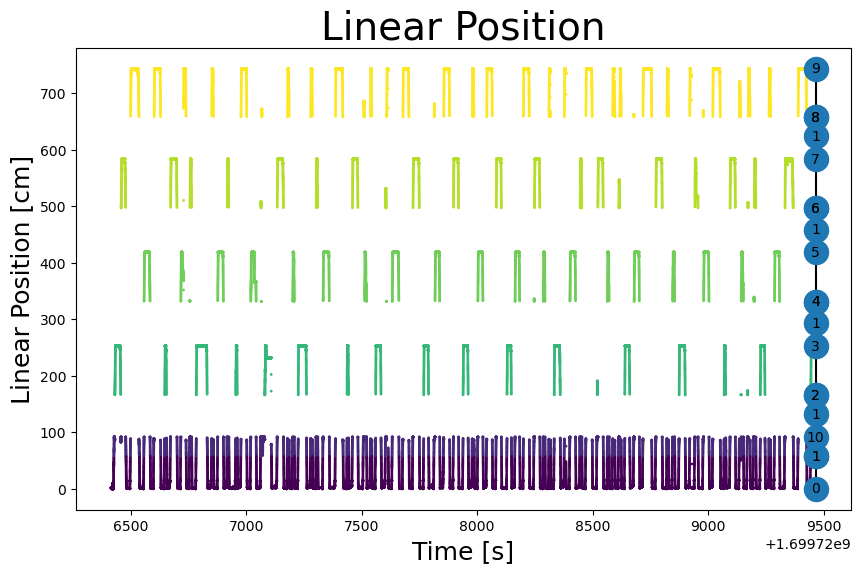

In [53]:
graph = TrackGraph() & {'track_graph_name': '4 arm lumped 2023'}

linear_position_df= (IntervalLinearizedPosition() &
                     {'position_info_param_name': 'default',
                      'nwb_file_name': nwb_copy_file_name,
                      'interval_list_name': 'pos 1 valid times',
                      'track_graph_name': '4 arm lumped 2023',
                      'linearization_param_name': 'default',
                     }).fetch1_dataframe()

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(linear_position_df.index,
            linear_position_df.linear_position,
            c=linear_position_df.track_segment_id,
            s=1)
graph.plot_track_graph_as_1D(
    ax=ax,
    axis='y',
    other_axis_start=linear_position_df.index[-1] + 10)

ax.set_xlabel('Time [s]', fontsize=18)
ax.set_ylabel('Linear Position [cm]', fontsize=18)
ax.set_title('Linear Position', fontsize=28)

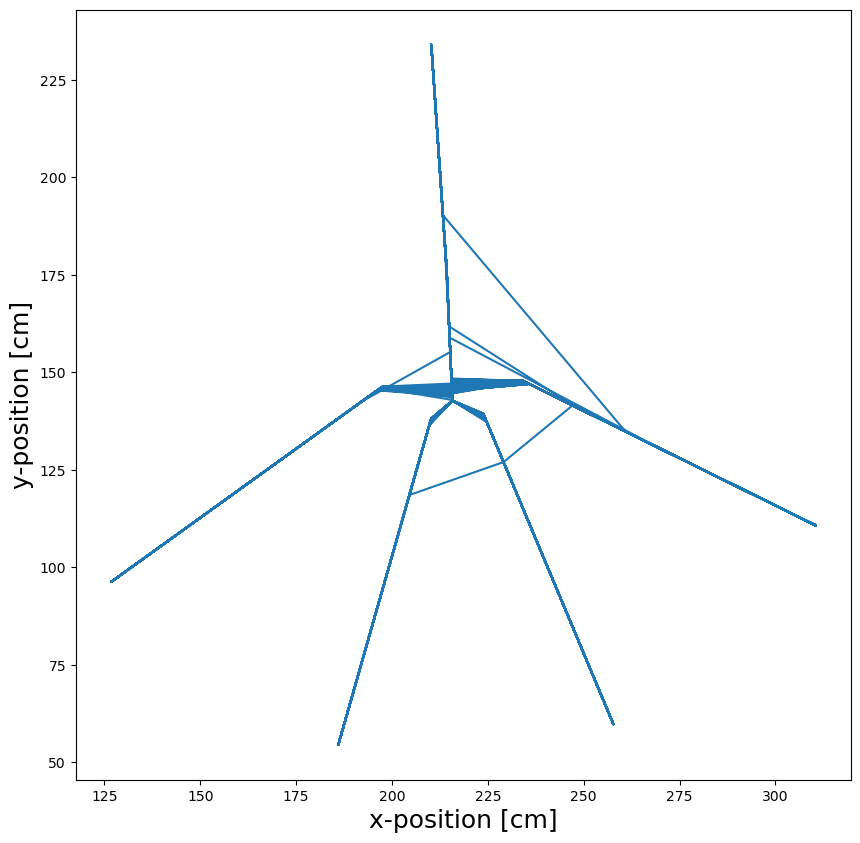

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
#ax.plot(position_info.head_position_x, position_info.head_position_y,
#        color='lightgrey', alpha=0.7, zorder=0)
ax.set_xlabel('x-position [cm]', fontsize=18)
ax.set_ylabel('y-position [cm]', fontsize=18)
ax.plot(linear_position_df.projected_x_position, linear_position_df.projected_y_position)